This notebools is based on the following paper:

>**The tricellular vertex-specific adhesion molecule Sidekick facilitates polarised cell intercalation during Drosophila axis extension** _Tara M Finegan, Nathan Hervieux, Alexander Nestor-Bergmann, Alexander G. Fletcher, Guy B Blanchard, Benedicte Sanson_ bioRxiv 704932; doi: https://doi.org/10.1101/704932 

In particular, the authors expose a nice way to account for rosettes and solve topology changes in a more generic and I think robust way than T1 transition. I think, it allows vertices with more than 3 out-edges to have a finite lifetime, and avoids T1 oscillations


I explore its implementation in [tyssue](https://github.com/damcb/tyssue), in 2D (also maybe in 3D, though it's less clear how :p).

In [1]:
# % conda install -c conda-forge tyssue

In [4]:
import numpy as np
import pandas as pd
import ipyvolume as ipv

import matplotlib.pylab as plt
%matplotlib inline


from tyssue import config
from tyssue import Monolayer, Sheet
from tyssue import PlanarGeometry as geom
from tyssue.generation import extrude
from tyssue.dynamics import model_factory, effectors
from tyssue.solvers.quasistatic import QSSolver

from tyssue.topology.base_topology import collapse_edge, remove_face
from tyssue.topology.sheet_topology import split_vert as sheet_split
from tyssue.topology.bulk_topology import split_vert as bulk_split

from tyssue.draw import sheet_view, highlight_cells

from tyssue.core.sheet import get_opposite

from tyssue.generation import single_cell
from tyssue.core.objects import _is_closed_cell
from tyssue.topology import condition_4i, condition_4ii

from tyssue.topology import connectivity

/home/guillaume/miniconda3/envs/tyssue/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/guillaume/miniconda3/envs/tyssue/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


### Create a small patch of cells in 2D and a simple mechanical model

In [38]:
sheet = Sheet.planar_sheet_2d('flat', 30, 30, 1, 1, noise=0.2)
to_cut = sheet.cut_out([(0.1, 6), (0.1, 6)])
sheet.remove(to_cut, trim_borders=True)
sheet.sanitize(trim_borders=True)
geom.center(sheet)
geom.update_all(sheet)
model = model_factory(
    [
        effectors.LineTension,
        effectors.FaceContractility,
        effectors.FaceAreaElasticity
    ]
)

specs = {
    "face": {
        "contractility": 5e-2,
        "prefered_area": sheet.face_df.area.mean(),
        "area_elasticity": 1.
    },
    "edge": {
        "line_tension": 1e-2,
        "is_active": 1
    },
    "vert": {
        "is_active": 1
    },
}

sheet.update_specs(specs, reset=True)

Reseting column is_active of the vert dataset with new specs


### Gradient descent

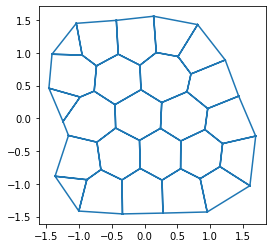

In [39]:
solver = QSSolver()

res = solver.find_energy_min(sheet, geom, model)

fig, ax = sheet_view(sheet, mode="quick")


## Formation of rosettes

<hr/>

![first screencap, forming rosettes](../data/png/finegan_etal_screencap1.png)

_Finegan et al. 2019_

In [40]:
# first let's get vertex ranks
# Note that this is 2 for border edges, might cause problems...


### Merge vertices

Or, said otherwize, collapse an edge

Maximum vertex rank:  4


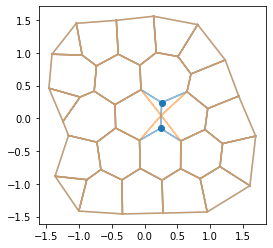

In [41]:
fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})
center_edge = sheet.edge_df.eval("sx**2 + sy**2").idxmin()
ax.scatter(sheet.edge_df.loc[center_edge, ["sx", "tx"]],
           sheet.edge_df.loc[center_edge, ["sy", "ty"]])

collapse_edge(sheet, center_edge)
update_rank(sheet)

geom.update_all(sheet)
fig, ax = sheet_view(sheet, mode="quick", ax=ax, edge={"alpha": 0.5})

print("Maximum vertex rank: ", sheet.vert_df['rank'].max())

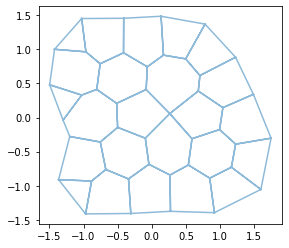

In [42]:
res = solver.find_energy_min(sheet, geom, model)
fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})


### Do it again to increase rank

Maximum vertex rank:  8


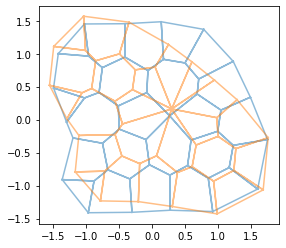

In [43]:
fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})

for i in range(4):
    center_edge = sheet.edge_df.eval("sx**2 + sy**2").idxmin()
    collapse_edge(sheet, center_edge)
    geom.update_all(sheet)
    res = solver.find_energy_min(sheet, geom, model)
    update_rank(sheet)

fig, ax = sheet_view(sheet, mode="quick", ax=ax, edge={"alpha": 0.5})


print("Maximum vertex rank: ", sheet.vert_df['rank'].max())

## Rosettes resolution

<hr/>

![Second screencap, solving rosettes](../data/png/finegan_etal_screencap2.png)

_Finegan et al. 2019_



As far as I understand, the difference between rank 5+ and rank 4 is not topological, but geometrical (the "old" vertex is moved towards the opposite cell center) and statistical because $p_4$ is higher than $p_{5+}$

### Solve for a single edge

Maximum vertex rank prior to rearangement:  8
Maximum vertex rank after rearangement:  7


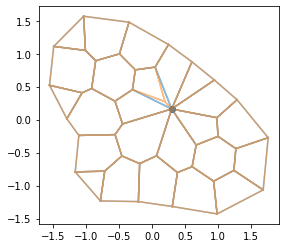

In [44]:
#sheet = bck.copy()
max_rank = sheet.vert_df['rank'].idxmax()

print("Maximum vertex rank prior to rearangement: ", sheet.vert_df['rank'].max())


fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})
max_rank_vert = sheet.vert_df['rank'].idxmax()

ax.scatter(sheet.vert_df.loc[max_rank_vert, "x"],
           sheet.vert_df.loc[max_rank_vert, "y"])

sheet_split(sheet, max_rank_vert)
update_rank(sheet)

geom.update_all(sheet)
fig, ax = sheet_view(sheet, mode="quick", ax=ax, edge={"alpha": 0.5})

print("Maximum vertex rank after rearangement: ", sheet.vert_df['rank'].max())


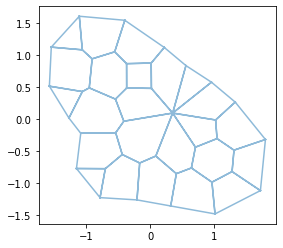

In [45]:
res = solver.find_energy_min(sheet, geom, model)
fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})

### Solve repeatedly

Maximum vertex rank prior to rearangement:  7
Maximum vertex rank:  6
Maximum vertex rank:  5
Maximum vertex rank:  4
Maximum vertex rank:  3


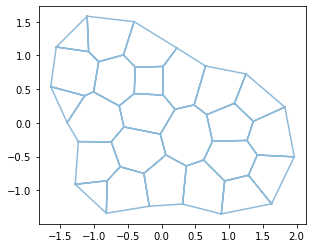

In [46]:
#sheet = bck.copy()
max_rank = sheet.vert_df['rank'].max()
print("Maximum vertex rank prior to rearangement: ", max_rank)

while max_rank > 3:
    max_rank_vert = sheet.vert_df['rank'].idxmax()

    sheet_split(sheet, max_rank_vert)
    update_rank(sheet)

    geom.update_all(sheet)

    res = solver.find_energy_min(sheet, geom, model)
    max_rank = sheet.vert_df['rank'].max()

    print("Maximum vertex rank: ", max_rank)

fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})

In [47]:
assert sheet.validate()

#### Collapse a face and resolve the rosette

In [48]:
remove_face(sheet, 12)
update_rank(sheet)
geom.update_all(sheet)

res = solver.find_energy_min(sheet, geom, model)

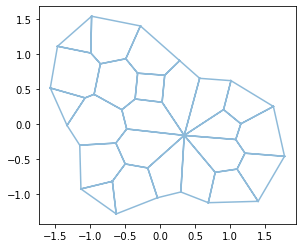

In [49]:
fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})


In [50]:
max_rank = sheet.vert_df['rank'].max()
while max_rank > 3:
    max_rank_vert = sheet.vert_df['rank'].idxmax()

    sheet_split(sheet, max_rank_vert)
    update_rank(sheet)

    geom.update_all(sheet)

    res = solver.find_energy_min(sheet, geom, model)
    max_rank = sheet.vert_df['rank'].max()

    print("Maximum vertex rank: ", max_rank)

Maximum vertex rank:  7
Maximum vertex rank:  6
Maximum vertex rank:  5
Maximum vertex rank:  4
Maximum vertex rank:  3


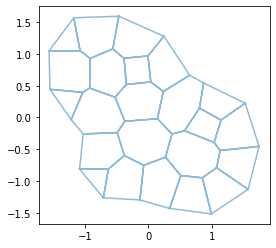

In [51]:
fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})

# How about in 3D?



### Extrude a monolayer from the previous sheet

In [55]:
from tyssue import MonolayerGeometry as geom

# Promote the sheet to 2.5 D
sheet.update_specs(config.geometry.sheet_spec())
# sheet = Sheet.planar_sheet_3d('flat', 8, 9, 1, 1, noise=0.1)
# to_cut = sheet.cut_out([(-10, 20), (-10, 20), (-10, 10)])
# sheet.remove(to_cut, trim_borders=True)
# sheet.sanitize(trim_borders=True)

specs = config.geometry.bulk_spec()
datasets = extrude(sheet.datasets, method='translation')
eptm = Monolayer('mono', datasets, specs)

geom.center(eptm)
geom.update_all(eptm) 

## Sanity check
assert eptm.validate()

### Setup a simple mechanical model and quasistatically descend it

In [81]:
model = model_factory([
    effectors.CellVolumeElasticity,
    effectors.FaceContractility,
    effectors.LineTension,
])

## Initial model settings
dyn_specs = {
    "settings": {
        "threshold_length": 1e-3,
    },
    "cell": {
        "prefered_vol": eptm.cell_df.vol.mean(),
        "prefered_area": eptm.cell_df.area.mean(),
        "vol_elasticity": 14.0,
        #"area_elasticity": 1.0,
    },
    "face": {
        #"surface_tension": 1.0,
        "contractility": 1e-2
    },
    "edge": {
        "line_tension": 0.01,
    }
}

## Those settings are set homogenously in the epithelium
eptm.update_specs(dyn_specs, reset=True)

# Lower the lateral contractility
eptm.face_df.loc[eptm.lateral_faces, 'contractility'] /= 2

solver = QSSolver(with_t1=False, with_t3=False)
res = solver.find_energy_min(eptm, geom, model)
update_rank(eptm)

ipv.clear()
eptm.face_df["visible"] =True
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)

ipv.show()

Reseting column prefered_vol of the cell dataset with new specs
Reseting column prefered_area of the cell dataset with new specs
Reseting column vol_elasticity of the cell dataset with new specs
Reseting column contractility of the face dataset with new specs
Reseting column line_tension of the edge dataset with new specs
/home/guillaume/miniconda3/envs/tyssue/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### Illustration of the split / collapse algorithm in 3D


![illustration of the rearangements](illus/IH_transition.png)

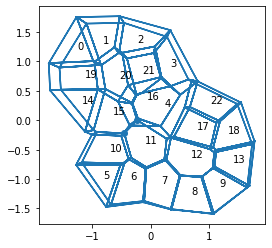

In [82]:
center_edge = eptm.edge_df.query('segment == "apical"').eval("sx**2 + sy**2").idxmin()

fig, ax = sheet_view(eptm, coords = ['x', 'y'], mode="quick")
for cell, (x, y) in eptm.cell_df[['x', 'y']].iterrows():
    ax.text(x, y, str(cell))
_= ax.scatter(
    eptm.edge_df.loc[center_edge, ['sx', 'tx']],
    eptm.edge_df.loc[center_edge, ['sy', 'ty']])


In [83]:
collapse_edge(eptm, center_edge)
geom.update_all(eptm)

update_rank(eptm)
print("Maximum vertex rank: ", eptm.vert_df['rank'].max())

ipv.clear()
eptm.face_df["visible"] = eptm.face_df['segment'] == "lateral"
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)

ipv.show()

assert eptm.validate()
update_rank(eptm)

print("Maximum vertex rank: ", eptm.vert_df['rank'].max())
vert = eptm.vert_df['rank'].idxmax()
print("Rosette index: ", vert)
bck = eptm.copy()


Maximum vertex rank:  6


Maximum vertex rank:  6
Rosette index:  18


In [84]:

eptm.settings['threshold_length'] = 0.1
bulk_split(eptm, vert, face=None, multiplier=2)

assert eptm.validate()

In [85]:
ipv.clear()
geom.update_all(eptm)
res = solver.find_energy_min(eptm, geom, model)

#eptm.face_df["visible"] = False
eptm.face_df["visible"] = eptm.face_df["segment"] == "lateral"
#eptm.face_df["visible"] = eptm.face_df.eval('(x**2 + (y+0.5)**2) < 0.5')
#eptm.face_df["visible"] = False

#eptm.face_df.loc[set(condition_4ii(eptm).ravel()[:2]), "visible"] = True
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)

ipv.show()

## Testing vertex split towards all possible faces

In [86]:
all_edges = bck.edge_df[
    (bck.edge_df["trgt"] == vert)
    | (bck.edge_df["srce"] == vert)
]


eptms = {}
for face, edge in all_edges.reset_index().groupby("face").first()['edge'].items():
    eptm = bck.copy()
    cell = eptm.edge_df.loc[edge, "cell"]
    print(f"splitting vertex {vert} towards cell {cell} over face {face}")
    bulk_split(eptm, vert, face=face, multiplier=2)
    assert eptm.validate()
    c4i, c4ii = condition_4i(eptm), condition_4ii(eptm)
    if len(c4i):
        print(f"\nIssue with face {face}")
        print("Number of condition 4i faces : ", len(c4i))
    if len(c4ii):
        print(f"\nIssue with face {face}")
        print("Number of condition 4ii faces : ", len(c4ii))
    
    eptms[face] = eptm


splitting vertex 18 towards cell 4 over face 4
splitting vertex 18 towards cell 10 over face 10
splitting vertex 18 towards cell 11 over face 11
splitting vertex 18 towards cell 15 over face 15
splitting vertex 18 towards cell 15 over face 116
splitting vertex 18 towards cell 10 over face 117
splitting vertex 18 towards cell 11 over face 118
splitting vertex 18 towards cell 15 over face 119
splitting vertex 18 towards cell 11 over face 124
splitting vertex 18 towards cell 10 over face 125
splitting vertex 18 towards cell 4 over face 154
splitting vertex 18 towards cell 11 over face 155
splitting vertex 18 towards cell 15 over face 160
splitting vertex 18 towards cell 4 over face 161


In [87]:
ipv.clear()
geom.update_all(eptm)

#eptm.face_df["visible"] = False
eptm.face_df["visible"] = eptm.face_df["segment"] == "lateral"
#eptm.face_df["visible"] = eptm.face_df.eval('(x**2 + (y+0.5)**2) < 0.5')
#eptm.face_df["visible"] = False

#eptm.face_df.loc[set(condition_4ii(eptm).ravel()[:2]), "visible"] = True
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)

ipv.show()

### Collapsing a cell

In [88]:
center_face = eptm.face_df.query("segment == 'apical'").eval("x**2 + y**2").idxmin()

remove_face(eptm, center_face)

0

In [67]:
ipv.clear()
geom.update_all(eptm)
res = solver.find_energy_min(eptm, geom, model)

#eptm.face_df["visible"] = False
eptm.face_df["visible"] = eptm.face_df["segment"] == "lateral"
#eptm.face_df["visible"] = eptm.face_df.eval('(x**2 + (y+0.5)**2) < 0.5')
#eptm.face_df["visible"] = False

#eptm.face_df.loc[set(condition_4ii(eptm).ravel()[:2]), "visible"] = True
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)

ipv.show()

### Split the created vertex

In [68]:
vert = eptm.vert_df.index[-1]

bulk_split(eptm, vert)


geom.update_all(eptm)

assert eptm.validate()

In [70]:
ipv.clear()
geom.update_all(eptm)
res = solver.find_energy_min(eptm, geom, model)

#eptm.face_df["visible"] = False
eptm.face_df["visible"] = eptm.face_df["segment"] == "lateral"
#eptm.face_df["visible"] = eptm.face_df.eval('(x**2 + (y+0.5)**2) < 0.5')
#eptm.face_df["visible"] = False

#eptm.face_df.loc[set(condition_4ii(eptm).ravel()[:2]), "visible"] = True
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)

ipv.show()

In [71]:
update_rank(eptm)

print("Maximum vertex rank: ", eptm.vert_df['rank'].max())

vert = eptm.vert_df['rank'].idxmax()
print("Rosette index: ", vert)

Maximum vertex rank:  10
Rosette index:  82


### Solve repeatedly

In [75]:
max_rank = eptm.vert_df['rank'].max()
while max_rank > 4:
    vert = eptm.vert_df['rank'].idxmax()
    bulk_split(eptm, vert)
    update_rank(eptm)
    max_rank = eptm.vert_df['rank'].max()
    print("Maximum vertex rank: ", max_rank)

    geom.update_all(eptm)
    res = solver.find_energy_min(eptm, geom, model)
    assert eptm.validate()

In [76]:
ipv.clear()
geom.update_all(eptm)

#eptm.face_df["visible"] = False
eptm.face_df["visible"] = eptm.face_df["segment"] == "lateral"
#eptm.face_df["visible"] = eptm.face_df.eval('(x**2 + (y+0.5)**2) < 0.5')
#eptm.face_df["visible"] = False

#eptm.face_df.loc[set(condition_4ii(eptm).ravel()[:2]), "visible"] = True
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)

ipv.show()